# Lorenz

Equations:

$$
\begin{cases}    
\dot{x}(t) = \sigma(y-x)\\
\dot{y}(t) = x(\rho-z)-y\\
\dot{z}(t) = xy-\beta z\\
\end{cases}
$$

In [193]:
!pip install torchdiffeq

In [194]:
import os
import argparse
import time
import psutil
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

In [195]:
method = 'rk4'
data_size = 1000
add_noise = True
irrspaced = False
data_noise = 0.001
batch_time = 200             # number of data points per batch
n_batches = 20              # number of batches
n_test_batches = 2
epochs = 2000
test_freq = 100
n_ensemble = 20
n_hidden = 50

anchored = False
reg = False
n_data = batch_time
W1_var = 1. 
W_last_var = 1/n_hidden
W1_lambda = data_noise/W1_var
b1_var = W1_var
b1_lambda =  data_noise/b1_var
W_last_lambda = data_noise/W_last_var

gpu = 0
viz = False
adjoint = False
scale = True
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

In [196]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [197]:
def memory_usage():
    process = psutil.Process(os.getpid())
    mem = process.memory_full_info()
    rss,vms,shared = mem[0],mem[1],mem[2]
    return rss,vms,shared

In [198]:
true_u0 = torch.tensor([[.5, .5, .5]]).to(device)
t = torch.linspace(0., 5., data_size).to(device)

In [199]:
class true_vector_field(nn.Module):

    def forward(self, t, u):
        x = u[0][0]
        y = u[0][1]
        z = u[0][2]
        
        sigma = 14.
        rho = 10.
        beta = 8/3

        dxdt = sigma*(y-x)
        dydt = x*(rho-z)-y
        dzdt = x*y-beta*z
        return torch.tensor([ 
                            [ dxdt ],
                            [ dydt ],
                            [ dzdt ]
                             ]).reshape([1,3]).to(device)


In [200]:
with torch.no_grad():
    true_u = odeint(true_vector_field(), true_u0, t, method=method) # [time,state] = [t,u(t)]
    non_scaled_true_u = true_u
    non_scaled_true_u0 = true_u0
    if scale:
        scaling = torch.max(true_u)
        true_u = true_u/scaling
        true_u0 = true_u0/scaling

In [201]:
if irrspaced:
    def get_batch():
        # randomly select initial time t0 for the batches
        # get randomly n_batches starting point by leaving the last n_test_batches batch for testing
        s = torch.from_numpy(np.random.choice(np.arange(data_size - (n_test_batches+2)*batch_time, dtype=np.int64), n_batches, replace=False))
        # select the initial value for each batch
        batch_y0 = true_u[s]  # (M, D)

        batch_tsteps = np.sort(np.random.choice(np.arange(2*batch_time),size=batch_time,replace=False))
        batch_t = t[batch_tsteps]  #t[:batch_time]  # (T)
        batch_y = torch.stack([true_u[s + i] for i in batch_tsteps], dim=0)  # (T, M, D) range(batch_time)
        batch_y = batch_y + int(add_noise)*torch.randn_like(batch_y)*data_noise
        return batch_y0.to(device), batch_t.to(device), batch_y.to(device), t[s]
else:
    def get_batch():
        # randomly select initial time t0 for the batches
        # get randomly n_batches starting point by leaving the last n_test_batches batch for testing
        s = torch.from_numpy(np.random.choice(np.arange(data_size - (n_test_batches+1)*batch_time, dtype=np.int64), n_batches, replace=False))
        # select the initial value for each batch
        batch_y0 = true_u[s]  # (M, D)
        batch_t = t[:batch_time]  # (T)
        batch_y = torch.stack([true_u[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
        batch_y = batch_y + int(add_noise)*torch.randn_like(batch_y)*data_noise
        return batch_y0.to(device), batch_t.to(device), batch_y.to(device), t[s]

In [202]:
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

In [203]:
if viz:
    makedirs('png')
    fig = plt.figure(figsize=(20, 6), facecolor='white')
#   ax_traj = fig.add_subplot(131, frameon=False)
    ax_phase_1 = fig.add_subplot(131, frameon=False)
    ax_phase_2 = fig.add_subplot(132, frameon=False)
    ax_phase_3 = fig.add_subplot(133, frameon=False)
#   ax_vecfield = fig.add_subplot(133, frameon=False)
    plt.show(block=False)

In [204]:
plot_x_lim = 3
plot_y_lim = 3

def visualize(true_u, pred_u, odefunc, itr, batch_y, batch_t):

    if viz:

        ax_phase_1.cla()
        ax_phase_1.set_title('Phase Portrait, Species 1-2')
        ax_phase_1.set_xlabel('x1')
        ax_phase_1.set_ylabel('x2')
        ax_phase_1.plot(true_u.cpu().numpy()[:, 0, 0], true_u.cpu().numpy()[:, 0, 1], 'g-')
        ax_phase_1.plot(pred_u.cpu().numpy()[:, 0, 0], pred_u.cpu().numpy()[:, 0, 1], 'b--')
        ax_phase_1.plot(batch_u0.cpu().numpy()[:, 0, 0], batch_u0.cpu().numpy()[:, 0, 1], 'r*')
        #ax_phase_1.set_xlim(0, plot_x_lim)
        #ax_phase_1.set_ylim(0, plot_y_lim)
        
        ax_phase_2.cla()
        ax_phase_2.set_title('Phase Portrait, Species 1-3')
        ax_phase_2.set_xlabel('x1')
        ax_phase_2.set_ylabel('x3')
        ax_phase_2.plot(true_u.cpu().numpy()[:, 0, 0], true_u.cpu().numpy()[:, 0, 2], 'g-')
        ax_phase_2.plot(pred_u.cpu().numpy()[:, 0, 0], pred_u.cpu().numpy()[:, 0, 2], 'b--')
        ax_phase_2.plot(batch_u0.cpu().numpy()[:, 0, 0], batch_u0.cpu().numpy()[:, 0, 2], 'r*')
        #ax_phase_2.set_xlim(0, plot_x_lim)
        #ax_phase_2.set_ylim(0, plot_y_lim)

        ax_phase_3.cla()
        ax_phase_3.set_title('Phase Portrait, Species 2-3')
        ax_phase_3.set_xlabel('x2')
        ax_phase_3.set_ylabel('x3')
        ax_phase_3.plot(true_u.cpu().numpy()[:, 0, 1], true_u.cpu().numpy()[:, 0, 2], 'g-')
        ax_phase_3.plot(pred_u.cpu().numpy()[:, 0, 1], pred_u.cpu().numpy()[:, 0, 2], 'b--')
        ax_phase_3.plot(batch_u0.cpu().numpy()[:, 0, 1], batch_u0.cpu().numpy()[:, 0, 2], 'r*')
        #ax_phase_3.set_xlim(0, plot_x_lim)
        #ax_phase_3.set_ylim(0, plot_y_lim)

        
        fig.tight_layout()
        fig.savefig('png/{:03d}'.format(itr))
        fig.show()
        #plt.draw()
        #plt.pause(0.001)

In [205]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, 3)
        )
        self.nfe=0
        
        self.net[0].weight.data.normal_(0.0, np.sqrt(W1_var))
        self.net[0].bias.data.normal_(0.0, np.sqrt(b1_var))
        self.net[2].weight.data.normal_(0.0, np.sqrt(W_last_var))
        self.net[2].bias.data.fill_(0.)

    def forward(self, t, y):
        self.nfe += 1
        return self.net(y)

In [206]:
def ensemble_pred(ensemble, u0, t):
  pred = torch.stack([odeint(func, true_u0, t,method=method).to(device) for func in ensemble])
  mean_pred = torch.mean(pred,0)
  std_pred = torch.std(pred,0)
  return pred,mean_pred,std_pred

# Extracted Data Visualization

In [207]:
batch_u0, batch_t, batch_u, ts = get_batch()
batch_u0.shape, batch_t.shape, batch_u.shape

(torch.Size([20, 1, 3]), torch.Size([200]), torch.Size([200, 20, 1, 3]))

Text(0, 0.5, 'z')

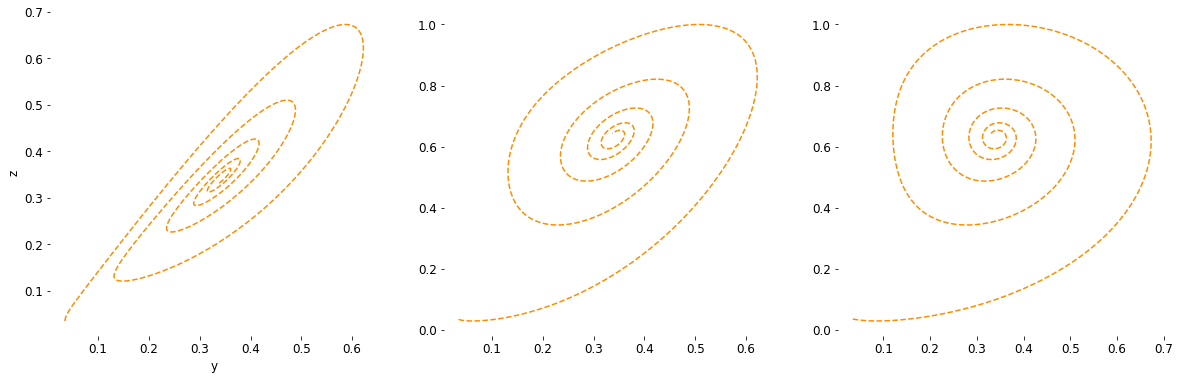

In [208]:
fig = plt.figure(figsize=(20, 6), facecolor='white')
plt.rcParams.update({'font.size': 12})
plt.rcParams['grid.linestyle'] = "--"
ax_phase_1_true = fig.add_subplot(131, frameon=False)
ax_phase_1_true.plot(true_u[:, :, 0].cpu(), true_u[:, :, 1].cpu(), '--',color='darkorange')
ax_phase_1_true.set_xlabel('x')
ax_phase_1_true.set_ylabel('y')
ax_phase_2_true = fig.add_subplot(132, frameon=False)
ax_phase_2_true.plot(true_u[:, :, 0].cpu(), true_u[:, :, 2].cpu(), '--',color='darkorange')
ax_phase_1_true.set_xlabel('x')
ax_phase_1_true.set_ylabel('z')
ax_phase_3_true = fig.add_subplot(133, frameon=False)
ax_phase_3_true.plot(true_u[:, :, 1].cpu(), true_u[:, :, 2].cpu(), '--',color='darkorange')
ax_phase_1_true.set_xlabel('y')
ax_phase_1_true.set_ylabel('z')

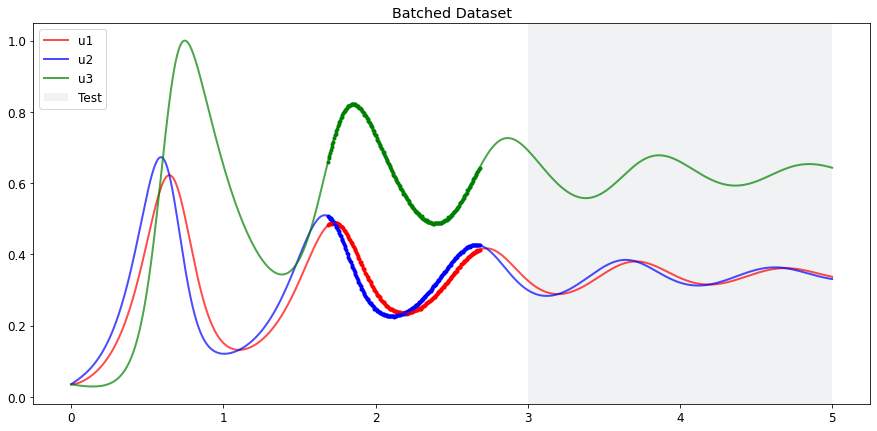

In [209]:
fig = plt.figure(figsize=(15, 7), facecolor='white',frameon=False)
plt.rcParams.update({'font.size': 12})
plt.rcParams['grid.linestyle'] = "--"
show_1_batch = True
batch_i=np.random.choice(range(n_batches))
batched_time = batch_t + ts[batch_i]*torch.ones_like(batch_t)

colors = ['r','b','g']

for j in range(3):
    lab = 'u'+str(j+1)
    #plt.scatter(ts.cpu().numpy(),batch_u0.cpu().numpy()[:,:,j],marker='o',color='silver')
    plt.plot(t.cpu().numpy(),true_u.cpu().numpy()[:, :, j],label=lab,color=colors[j],alpha=0.7,linewidth=2)
    if show_1_batch:
            plt.scatter(batched_time.cpu().numpy(),batch_u.cpu().numpy()[:,batch_i,:,j],color=colors[j],marker='.',alpha=1)
    else:
        for batch_i in range(n_batches):
            batched_time = batch_t + ts[batch_i]*torch.ones_like(batch_t)
            plt.scatter(batched_time.cpu().numpy(),batch_u.cpu().numpy()[:,batch_i,:,j],color=colors[j],marker='o',alpha=.1)


#plt.plot(t,true_u[:, :, j],'--r',label='Ground truth')
plt.axvspan(t[data_size-n_test_batches*batch_time].cpu().numpy(), t[-1].cpu().numpy(), facecolor='slategrey', alpha=0.1,label='Test')

plt.title('Batched Dataset')
plt.legend()

## Training

In [210]:
func = ODEFunc().to(device)

In [211]:
batch_u0, batch_t, batch_u, ts = get_batch()
pred_u = odeint(func, batch_u0[0], batch_t,method=method).to(device)
print(func.nfe)
func.nfe=0

796


In [212]:
batch_t.shape, batch_u0.shape

(torch.Size([200]), torch.Size([20, 1, 3]))

In [213]:
ii = 0
lrate = 1e-3


optimizer = optim.RMSprop(func.parameters(), lr=lrate)

W1_anc = np.random.normal(loc=0,scale=np.sqrt(W1_var),size=[n_hidden,1])
b1_anc = np.random.normal(loc=0,scale=np.sqrt(b1_var),size=[n_hidden])
W_last_anc = np.random.normal(loc=0,scale=np.sqrt(W_last_var),size=[1,n_hidden])
W1_anc = torch.tensor(W1_anc).float().to(device)
b1_anc = torch.tensor(b1_anc).float().to(device)
W_last_anc = torch.tensor(W_last_anc).float().to(device)

loss_array = []
itr_time = []
nfe = []
rss_mem,vms_mem,shared_mem = [],[],[]
start = time.time()

for itr in range(1, epochs + 1):

    start_itr = time.time()


    batch_u0, batch_t, batch_u, ts = get_batch()
    pred_u = odeint(func, batch_u0, batch_t,method=method).to(device)
    nfe.append(func.nfe)
    func.nfe=0
    l2 = 0
    
    if reg:
    #   l2 += W1_lambda/n_data * torch.mean(torch.pow(func.net[0].weight - W1_anc, 2))
    #   l2 += b1_lambda/n_data * torch.mean(torch.pow(func.net[0].bias - b1_anc, 2))
    #   l2 += W_last_lambda/n_data * torch.mean(torch.pow(func.net[2].weight - W_last_anc, 2))
        l2 += W1_lambda/n_data * (torch.pow(func.net[0].weight, 2)).sum()
        l2 += b1_lambda/n_data * (torch.pow(func.net[0].bias, 2)).sum()
        l2 += W_last_lambda/n_data * (torch.pow(func.net[2].weight, 2)).sum()
        
    if anchored:
    #   l2 += W1_lambda/n_data * torch.mean(torch.pow(func.net[0].weight - W1_anc, 2))
    #   l2 += b1_lambda/n_data * torch.mean(torch.pow(func.net[0].bias - b1_anc, 2))
    #   l2 += W_last_lambda/n_data * torch.mean(torch.pow(func.net[2].weight - W_last_anc, 2))
        l2 += W1_lambda/n_data * (torch.pow(func.net[0].weight - W1_anc, 2)).sum()
        l2 += b1_lambda/n_data * (torch.pow(func.net[0].bias - b1_anc, 2)).sum()
        l2 += W_last_lambda/n_data * (torch.pow(func.net[2].weight - W_last_anc, 2)).sum()

    loss = torch.mean(torch.pow(pred_u - batch_u,2)) + l2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    rss,vms,shared = memory_usage()
    rss_mem.append(rss)
    vms_mem.append(vms)
    shared_mem.append(shared)
    itr_time.append(time.time()-start_itr)
    loss_array.append(loss.item())

    if itr % test_freq == 0:
        with torch.no_grad():
            print('Iter ' + str(itr)+'/'+str(epochs) + '\t|  Loss: ' + str(round(loss.item(),6)) + '\t|  lr: ' + str(optimizer.param_groups[0]['lr']) + '\t|  itr time: ' +str(round(itr_time[-1],5))+' s\t memory usage: '+str(rss))
            #       visualize(true_u, pred_u, func, ii, batch_u0, batch_t)
            #       ii += 1

total_elapsed_time = time.time()-start

Iter 100/2000	|  Loss: 0.030436	|  lr: 0.001	|  itr time: 0.66796 s	 memory usage: 2197893120
Iter 200/2000	|  Loss: 0.023669	|  lr: 0.001	|  itr time: 0.64804 s	 memory usage: 2197893120
Iter 300/2000	|  Loss: 0.018717	|  lr: 0.001	|  itr time: 0.64522 s	 memory usage: 2197893120
Iter 400/2000	|  Loss: 0.020627	|  lr: 0.001	|  itr time: 0.65128 s	 memory usage: 2197893120
Iter 500/2000	|  Loss: 0.012513	|  lr: 0.001	|  itr time: 0.66128 s	 memory usage: 2197893120
Iter 600/2000	|  Loss: 0.006333	|  lr: 0.001	|  itr time: 0.91937 s	 memory usage: 2197893120
Iter 700/2000	|  Loss: 0.003542	|  lr: 0.001	|  itr time: 0.65465 s	 memory usage: 2197893120
Iter 800/2000	|  Loss: 0.003166	|  lr: 0.001	|  itr time: 0.67255 s	 memory usage: 2197893120
Iter 900/2000	|  Loss: 0.004455	|  lr: 0.001	|  itr time: 0.65992 s	 memory usage: 2197893120
Iter 1000/2000	|  Loss: 0.003403	|  lr: 0.001	|  itr time: 0.65363 s	 memory usage: 2197893120
Iter 1100/2000	|  Loss: 0.003796	|  lr: 0.001	|  itr time: 

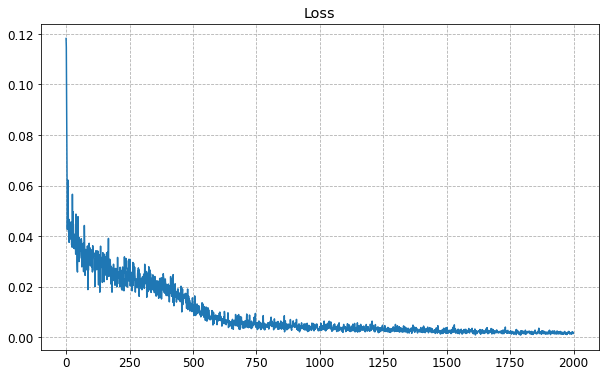

In [214]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 12})
plt.rcParams['grid.linestyle'] = "--"
plt.plot(loss_array)
plt.grid()
plt.title('Loss')
plt.savefig('loss.png',dpi=200)

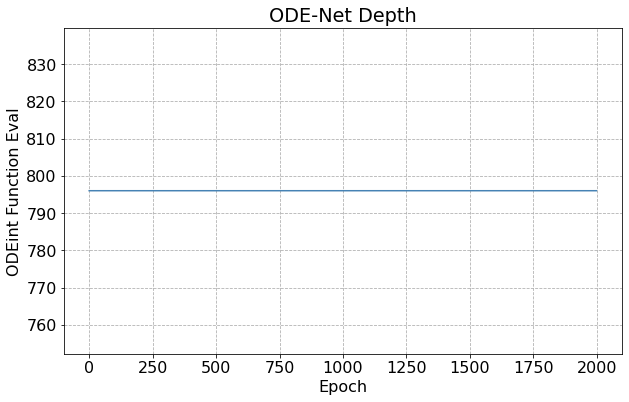

In [215]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 16})
plt.rcParams['grid.linestyle'] = "--"
plt.grid()
#nfe_ = np.array(nfe)/20
plt.plot(nfe,color='steelblue')
plt.xlabel('Epoch')
plt.ylabel('ODEint Function Eval')
plt.title('ODE-Net Depth')
plt.savefig('depth.png',dpi=200)

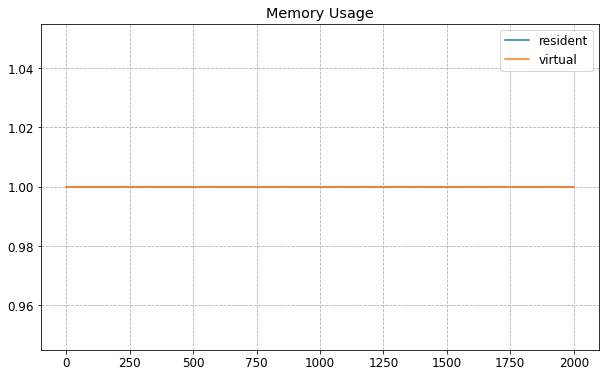

In [216]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 12})
plt.rcParams['grid.linestyle'] = "--"
plt.plot(np.array(rss_mem)/max(rss_mem),label='resident')
plt.plot(np.array(vms_mem)/max(vms_mem),label='virtual')
#plt.plot(np.array(shared_mem)/max(shared_mem),label='shared')
plt.grid()
plt.title('Memory Usage')
plt.legend()
plt.savefig('memory.png',dpi=200)

## Test

In [217]:
pred = odeint(func, true_u0, t, method=method).to(device)
pred_train = pred[:600]
pred_test = pred[600:]

In [218]:
def info():
    print('ODEint Method: ', method)
    print('Adjoint: ', adjoint)
    print('Irregularly spaced data: ', irrspaced)
    print('Training time: {:f} min\t| avg time per epoch : {:f} s'.format(total_elapsed_time/60, np.mean(np.array(itr_time))))
    print('MSE: ',float(torch.mean(torch.pow(pred-true_u,2))), '\t| MAE: ',float(torch.mean(torch.abs(pred-true_u))))
    print('MSE Train: ',float(torch.mean(torch.pow(pred_train-true_u[:600],2))), '\t| MAE Train: ',float(torch.mean(torch.abs(pred_train-true_u[:600]))))
    print('MSE Test: ',float(torch.mean(torch.pow(pred_test-true_u[600:],2))), '\t| MAE Test: ',float(torch.mean(torch.abs(pred_test-true_u[600:]))))
    print('Max NFE: ', max(nfe),'\t| Min NFE: ', min(nfe))

In [219]:
gtc = 'r'
c_pred = 'b'
a=.3

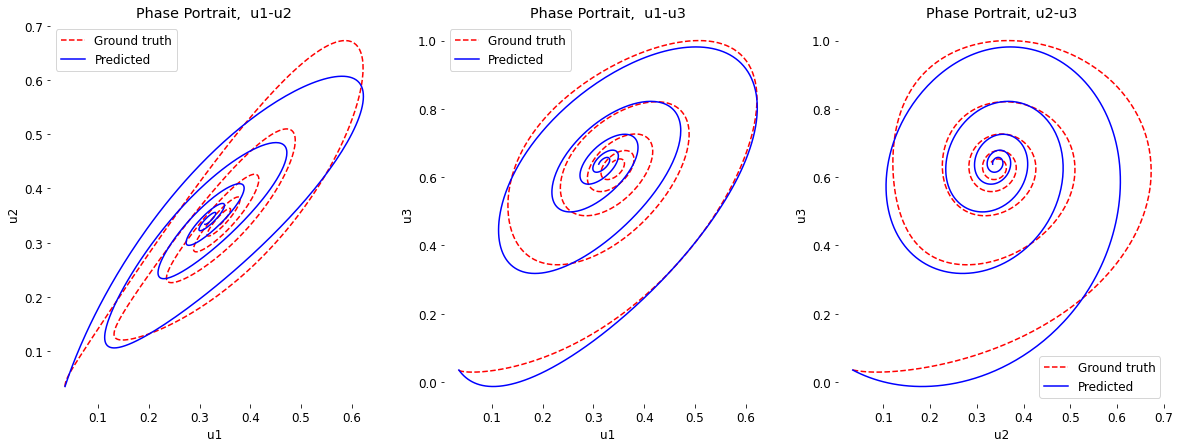

In [220]:
with torch.no_grad():

    fig = plt.figure(figsize=(20, 7), facecolor='white')
    plt.rcParams.update({'font.size': 12})
    plt.rcParams['grid.linestyle'] = "--"
    ax_phase_1_test = fig.add_subplot(131, frameon=False)
    ax_phase_1_test.set_title('Phase Portrait,  u1-u2')
    ax_phase_1_test.set_xlabel('u1')
    ax_phase_1_test.set_ylabel('u2')
    ax_phase_1_test.plot(true_u[:, :, 0].cpu(), true_u[:, :, 1].cpu(), '--', color=gtc,label='Ground truth')
    ax_phase_1_test.plot(pred[:, :, 0].cpu(), pred[:, :, 1].cpu(), '-', color=c_pred,label='Predicted')


    ax_phase_2_test = fig.add_subplot(132, frameon=False)
    ax_phase_2_test.set_title('Phase Portrait,  u1-u3')
    ax_phase_2_test.set_xlabel('u1')
    ax_phase_2_test.set_ylabel('u3')
    ax_phase_2_test.plot(true_u[:, :, 0].cpu(), true_u[:, :, 2].cpu(), '--', color=gtc,label='Ground truth')
    ax_phase_2_test.plot(pred[:, :, 0].cpu(), pred[:, :, 2].cpu(), '-', color=c_pred,label='Predicted')


    ax_phase_3_test = fig.add_subplot(133, frameon=False)
    ax_phase_3_test.set_title('Phase Portrait, u2-u3')
    ax_phase_3_test.set_xlabel('u2')
    ax_phase_3_test.set_ylabel('u3')
    ax_phase_3_test.plot(true_u[:, :, 1].cpu(), true_u[:, :, 2].cpu(), '--', color=gtc,label='Ground truth')
    ax_phase_3_test.plot(pred[:, :, 1].cpu(), pred[:, :, 2].cpu(), '-', color=c_pred,label='Predicted')

    ax_phase_1_test.legend()
    ax_phase_2_test.legend()
    ax_phase_3_test.legend()

/opt/conda/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/opt/conda/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


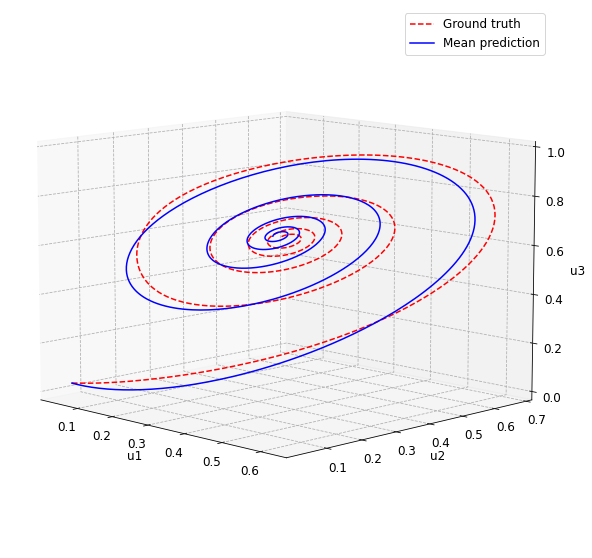

In [221]:
with torch.no_grad():
    fig = plt.figure(figsize=(10,10))
    plt.rcParams.update({'font.size': 12})
    plt.rcParams['grid.linestyle'] = "--"
    ax = plt.axes(projection='3d')


    ax.plot3D(true_u[:, :, 0].cpu().flatten(), true_u[:, :, 1].cpu().flatten(), true_u[:, :, 2].cpu().flatten(),'--',color=gtc,label='Ground truth')
    ax.plot3D(pred[:, :, 0].cpu().flatten(), pred[:, :, 1].cpu().flatten(), pred[:, :, 2].cpu().flatten(),color=c_pred,label='Mean prediction')

    ax.view_init(10, -45)
    ax.set_xlabel('u1')
    ax.set_ylabel('u2')
    ax.set_zlabel('u3')

    ax.legend() 
    plt.savefig('orbits3d.png',dpi=200)

/opt/conda/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/opt/conda/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


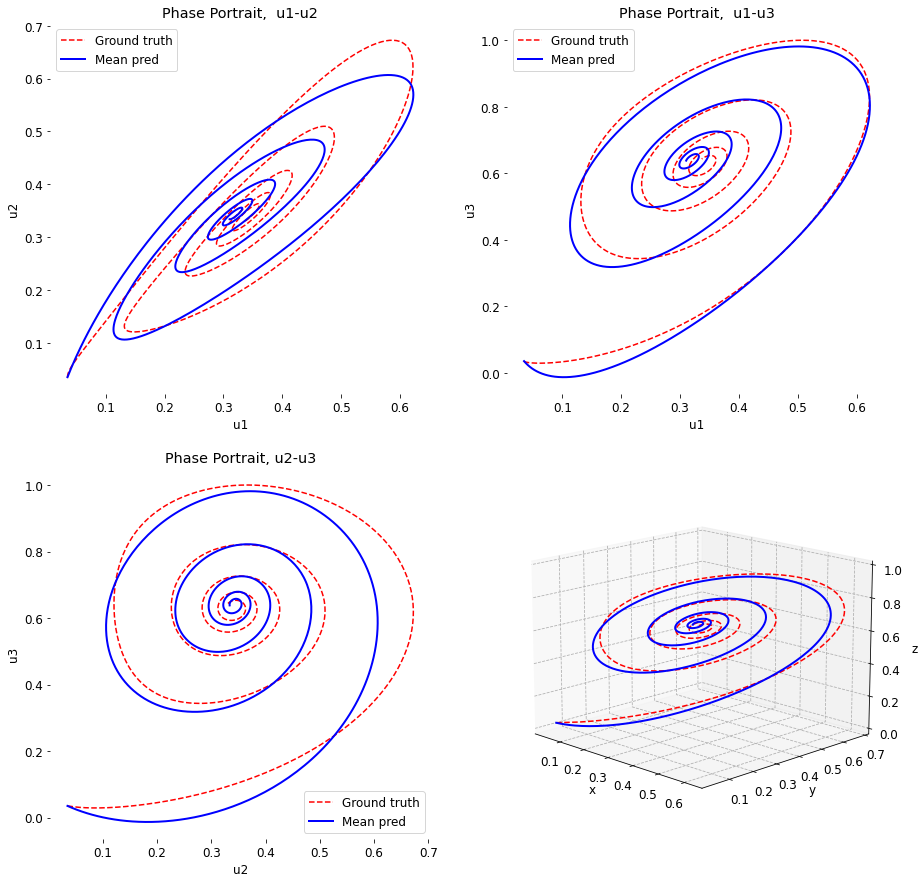

In [222]:
with torch.no_grad():

    fig = plt.figure(figsize=(15, 15), facecolor='white')
    plt.rcParams.update({'font.size': 12})
    plt.rcParams['grid.linestyle'] = "--"
    ax_phase_1_test = fig.add_subplot(221, frameon=False)
    ax_phase_1_test.set_title('Phase Portrait,  u1-u2')
    ax_phase_1_test.set_xlabel('u1')
    ax_phase_1_test.set_ylabel('u2')
    ax_phase_1_test.plot(true_u[:, :, 0].cpu(), true_u[:, :, 1].cpu(), '--', color=gtc,label='Ground truth')
    ax_phase_1_test.plot(pred[:, :, 0].cpu(), pred[:, :, 1].cpu(), '-', color=c_pred,label='Mean pred',linewidth=2)


    ax_phase_2_test = fig.add_subplot(222, frameon=False)
    ax_phase_2_test.set_title('Phase Portrait,  u1-u3')
    ax_phase_2_test.set_xlabel('u1')
    ax_phase_2_test.set_ylabel('u3')
    ax_phase_2_test.plot(true_u[:, :, 0].cpu(), true_u[:, :, 2].cpu(), '--', color=gtc,label='Ground truth')
    ax_phase_2_test.plot(pred[:, :, 0].cpu(), pred[:, :, 2].cpu(), '-', color=c_pred,label='Mean pred',linewidth=2)


    ax_phase_3_test = fig.add_subplot(223, frameon=False)
    ax_phase_3_test.set_title('Phase Portrait, u2-u3')
    ax_phase_3_test.set_xlabel('u2')
    ax_phase_3_test.set_ylabel('u3')
    ax_phase_3_test.plot(true_u[:, :, 1].cpu(), true_u[:, :, 2].cpu(), '--', color=gtc,label='Ground truth')
    ax_phase_3_test.plot(pred[:, :, 1].cpu(), pred[:, :, 2].cpu(), '-', color=c_pred,label='Mean pred',linewidth=2)


    ax_3dphase_test = fig.add_subplot(224, projection='3d')

    ax_3dphase_test.plot3D(true_u[:, :, 0].cpu().flatten(), true_u[:, :, 1].cpu().flatten(), true_u[:, :, 2].cpu().flatten(),'--',color=gtc,label='Ground truth')
    ax_3dphase_test.plot3D(pred[:, :, 0].cpu().flatten(), pred[:, :, 1].cpu().flatten(), pred[:, :, 2].cpu().flatten(),color=c_pred,label='Mean prediction',linewidth=2)
   
    ax_3dphase_test.view_init(15, -45)
    ax_3dphase_test.set_xlabel('x')
    ax_3dphase_test.set_ylabel('y')
    ax_3dphase_test.set_zlabel('z')
    
    ax_phase_1_test.legend()
    ax_phase_2_test.legend()
    ax_phase_3_test.legend()

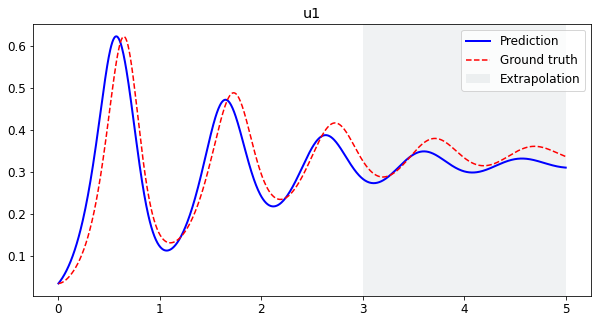

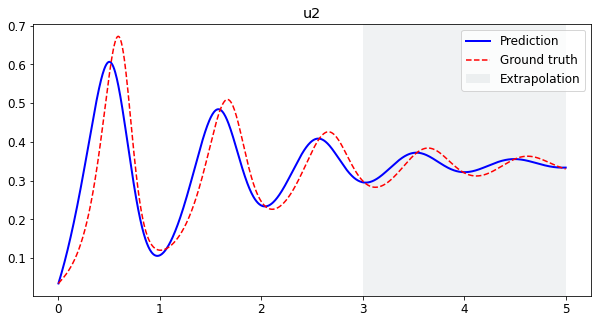

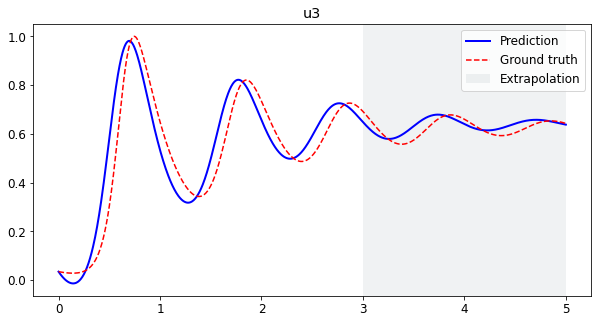

In [223]:
with torch.no_grad():

  for j in range(3):
    fig = plt.figure(figsize=(10, 5), facecolor='white',frameon=False)
    plt.plot(t.cpu(),pred[:, :, j].cpu(),color=c_pred,linewidth=2,label='Prediction')
    #plt.scatter(batch_t,batch_u[:,0,:,j])
    plt.plot(t.cpu(),true_u[:, :, j].cpu(),'--',color=gtc,label='Ground truth')
    plt.axvspan(t[data_size-n_test_batches*batch_time].cpu(), t[-1].cpu(), facecolor='slategrey', alpha=0.1,label='Extrapolation')
    plt.title('u'+str(j+1))
    plt.legend()
    plt.savefig('u'+str(j+1)+'.png',dpi=200)

In [224]:
info()

ODEint Method:  rk4
Adjoint:  False
Irregularly spaced data:  False
Training time: 22.985251 min	| avg time per epoch : 0.689464 s
MSE:  0.004018441308289766 	| MAE:  0.0446062833070755
MSE Train:  0.006301005836576223 	| MAE Train:  0.060965947806835175
MSE Test:  0.0005945946904830635 	| MAE Test:  0.02006678283214569
Max NFE:  796 	| Min NFE:  796


In [225]:
#torch.save(func,'odenet_rk4_adjoint.pt')